# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [1]:
# dataframes 
import numpy as np
# import pandas as pd
import polars as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier
import xgboost as xgb

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
import sys
sys.path.append('../') # los archivos están en la carpeta anterior
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# LECTURA DE DATOS

In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('../parametros_ml.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:01,  3.67it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:00<00:01,  3.76it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:00<00:01,  3.73it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  3.74it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:01<00:00,  3.54it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:01<00:00,  3.49it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:01<00:00,  3.55it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


njet30          mjj      detajj  \
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603   
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb  \
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486   
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta  \
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121   
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt  \
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000   
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

array([[<Axes: title={'center': 'njet30'}>,
        <Axes: title={'center': 'mjj'}>,
        <Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'dphijj'}>],
       [<Axes: title={'center': 'MET'}>,
        <Axes: title={'center': 'scale1fb'}>,
        <Axes: title={'center': 'intLumi'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_eta'}>,
        <Axes: title={'center': 'jet1_phi'}>,
        <Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>],
       [<Axes: title={'center': 'jet2_eta'}>,
        <Axes: title={'center': 'jet2_phi'}>,
        <Axes: title={'center': 'jet2_e'}>, <Axes: >]], dtype=object)

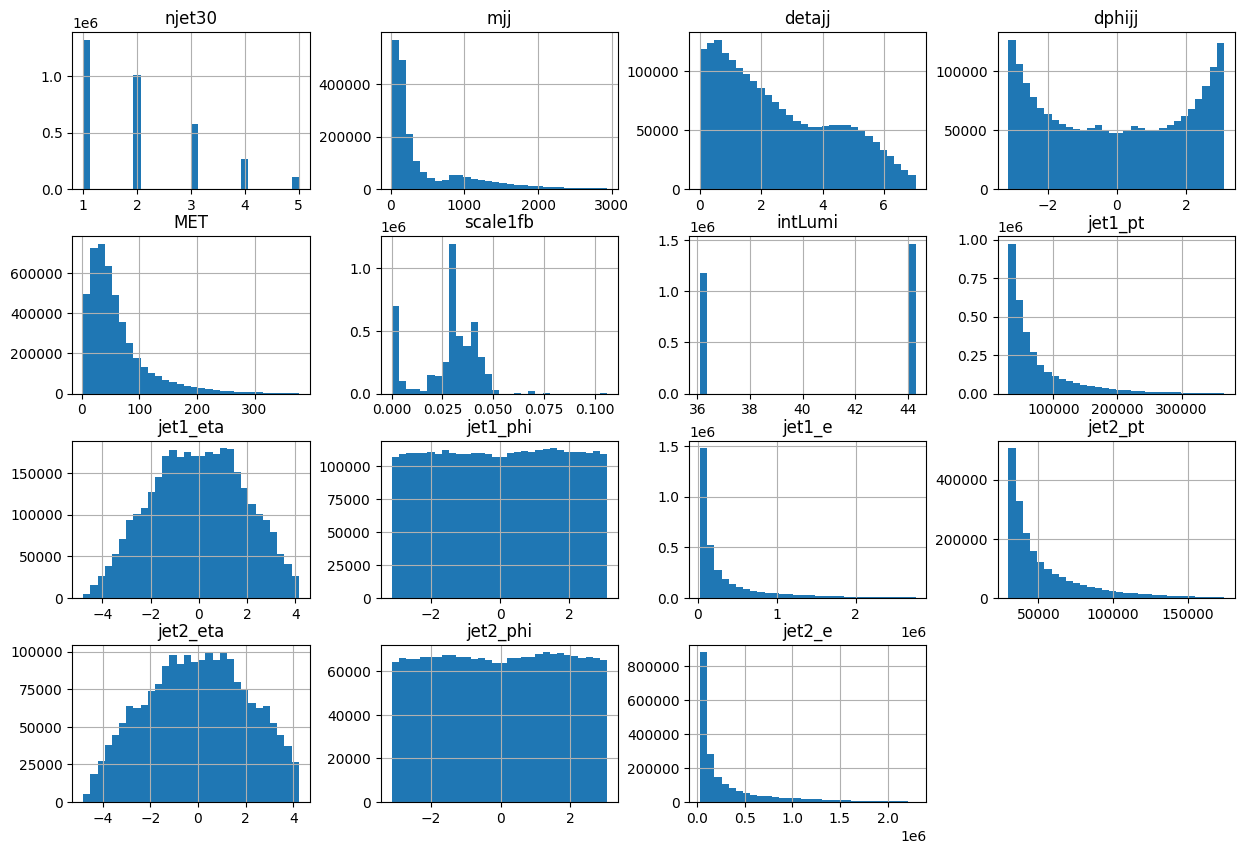

In [4]:
df_plot = df_all[(df_all > df_all.quantile(0.005)) & (df_all < df_all.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# CORTES Y PREPROCESADO

In [5]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all_cut
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 

Numero eventos antes: 2013265
Corte: mjj entre [900000, inf]
Numero eventos despues: 401061 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
4,1959.747314,5.296212,-0.007301,173.871338,185329.890625,-1.776462,-0.692636,5.636762e+05,104825.007812,3.519750,-0.685335,1.771840e+06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400510,1375.437012,5.910862,-1.310179,206.011978,153233.453125,-2.751994,-2.272271,1.205820e+06,33497.703125,3.158869,-0.962092,3.950761e+05,0,1
400511,1298.385620,5.570216,1.490798,204.691193,94238.859375,2.544895,1.564830,6.042351e+05,68172.960938,-3.025321,0.074032,7.038728e+05,0,1
400512,1024.361084,6.604571,-2.378259,30.073345,43778.152344,3.034697,2.696079,4.563027e+05,32387.500000,-3.569874,-1.208847,5.755651e+05,0,1
400513,1099.484253,6.322570,-0.535331,151.870178,51457.390625,-3.545921,1.085866,8.928492e+05,42295.820312,2.776649,1.621197,3.411398e+05,0,1


array([[<Axes: title={'center': 'njet30'}>,
        <Axes: title={'center': 'mjj'}>,
        <Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'dphijj'}>],
       [<Axes: title={'center': 'MET'}>,
        <Axes: title={'center': 'scale1fb'}>,
        <Axes: title={'center': 'intLumi'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_eta'}>,
        <Axes: title={'center': 'jet1_phi'}>,
        <Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>],
       [<Axes: title={'center': 'jet2_eta'}>,
        <Axes: title={'center': 'jet2_phi'}>,
        <Axes: title={'center': 'jet2_e'}>, <Axes: >]], dtype=object)

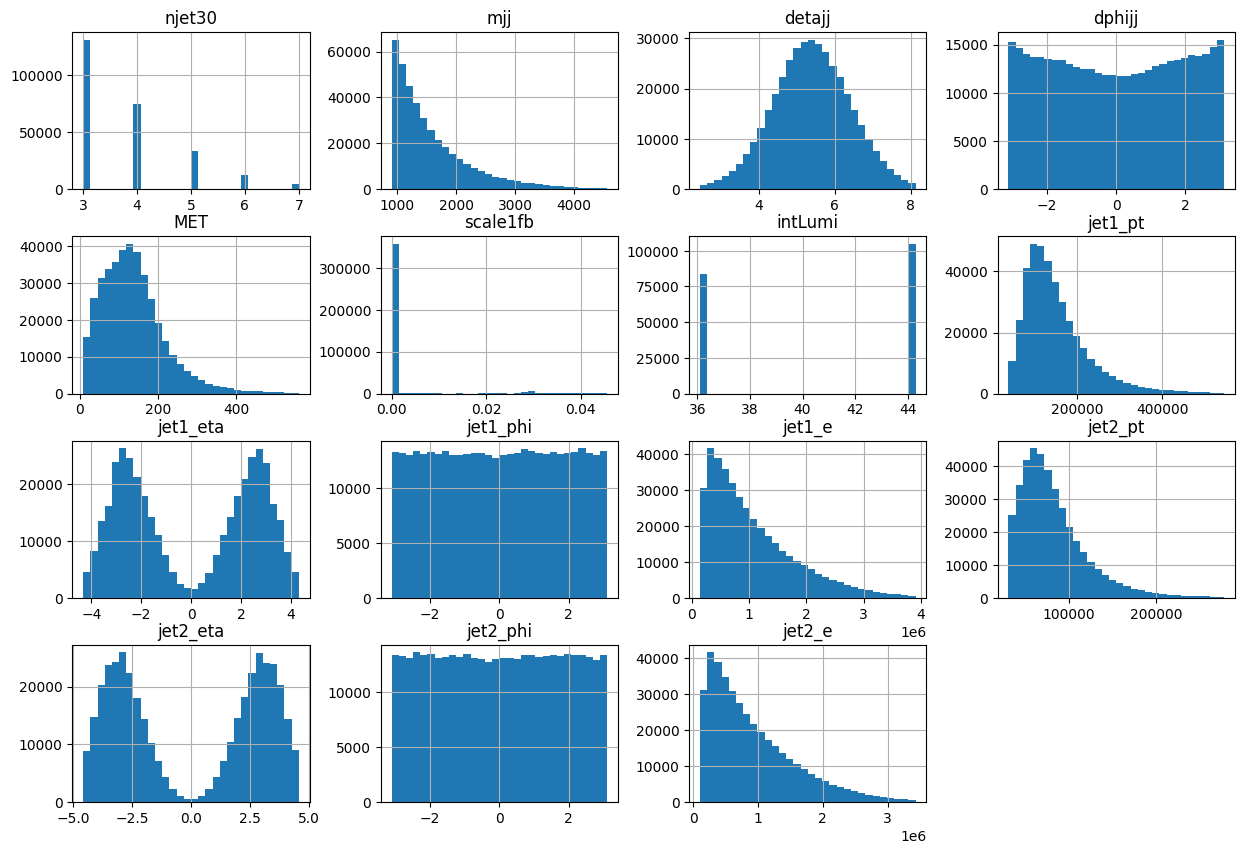

In [6]:
df_plot = df_all_cut[(df_all_cut > df_all_cut.quantile(0.005)) & (df_all_cut < df_all_cut.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# ANALISIS PREVIO

In [7]:
# veamos si hago bien el corte de njet30
# sns.histplot(data = df_all["njet30"], bins=30)
# sí se borraban cosas, habian datos originalmente con njet30 con valores 0 o 1, la cosa que me decía el número de entradas antes y después no estaba actualizado para el código actual

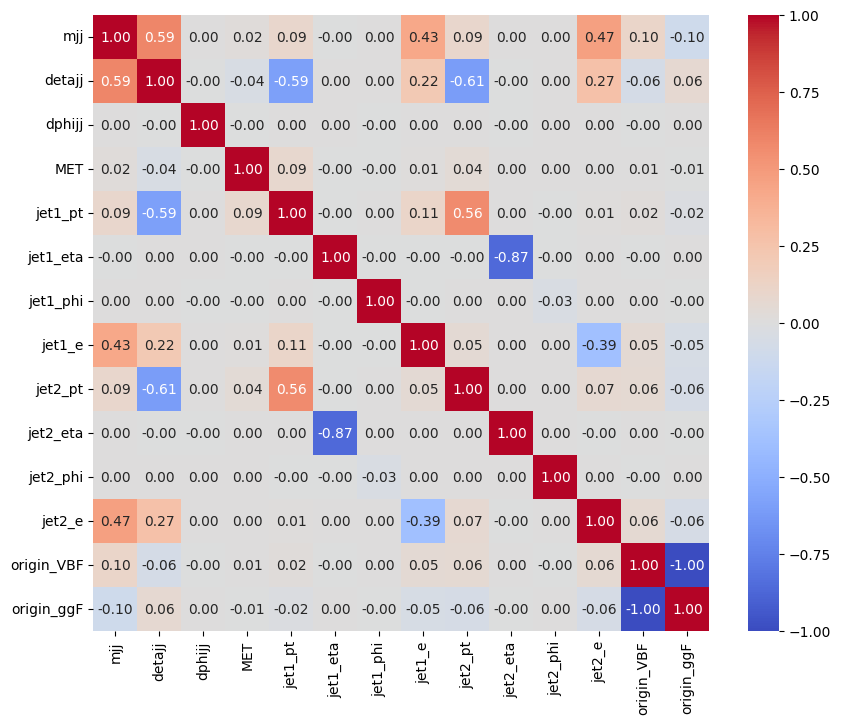

In [8]:
########################################################
##################### CORRELACION ######################
########################################################

plot_correlacion(df_ml)

In [9]:
# ver las correlaciones en orden de importancia con origin vbf
correlaciones(df_ml, "origin_VBF")

origin_VBF    1.000000
mjj           0.103147
jet2_pt       0.060196
jet2_e        0.057928
jet1_e        0.051375
jet1_pt       0.022996
MET           0.006948
jet1_phi      0.003644
jet2_eta      0.002823
dphijj       -0.001464
jet2_phi     -0.001526
jet1_eta     -0.002031
detajj       -0.064225
origin_ggF   -1.000000
Name: origin_VBF, dtype: float64

borro las de menor relevancia: MET, jet1_phi, jet2_eta, dphijj, jet2_phi, jet1_eta
Ademas borro MET porque no aporta en nada

# PREPROCESADO MEJORADO TRAS ANALISIS

# AQUI ELIMINO MJJ

In [10]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi', 'mjj'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]
# df_y = df_ml[["origin_ggF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
# X_test, y_test = X_metrico, y_metrico 

df_ml2

,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
3,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
4,5.296212,185329.890625,5.636762e+05,104825.007812,1.771840e+06,1
...,...,...,...,...,...,...
400510,5.910862,153233.453125,1.205820e+06,33497.703125,3.950761e+05,0
400511,5.570216,94238.859375,6.042351e+05,68172.960938,7.038728e+05,0
400512,6.604571,43778.152344,4.563027e+05,32387.500000,5.755651e+05,0
400513,6.322570,51457.390625,8.928492e+05,42295.820312,3.411398e+05,0


nota: no cambió en nada el resultado, no afectó las cosas que borré

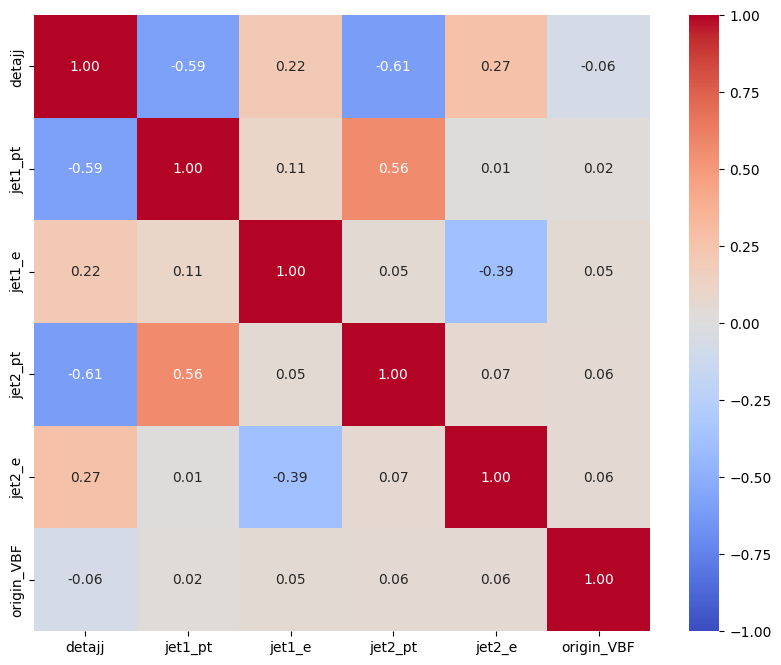

In [11]:
plot_correlacion(df_ml2)

In [12]:
correlaciones(df_ml2, "origin_VBF")

origin_VBF    1.000000
jet2_pt       0.060196
jet2_e        0.057928
jet1_e        0.051375
jet1_pt       0.022996
detajj       -0.064225
Name: origin_VBF, dtype: float64

array([[<Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>],
       [<Axes: title={'center': 'jet2_e'}>,
        <Axes: title={'center': 'origin_VBF'}>]], dtype=object)

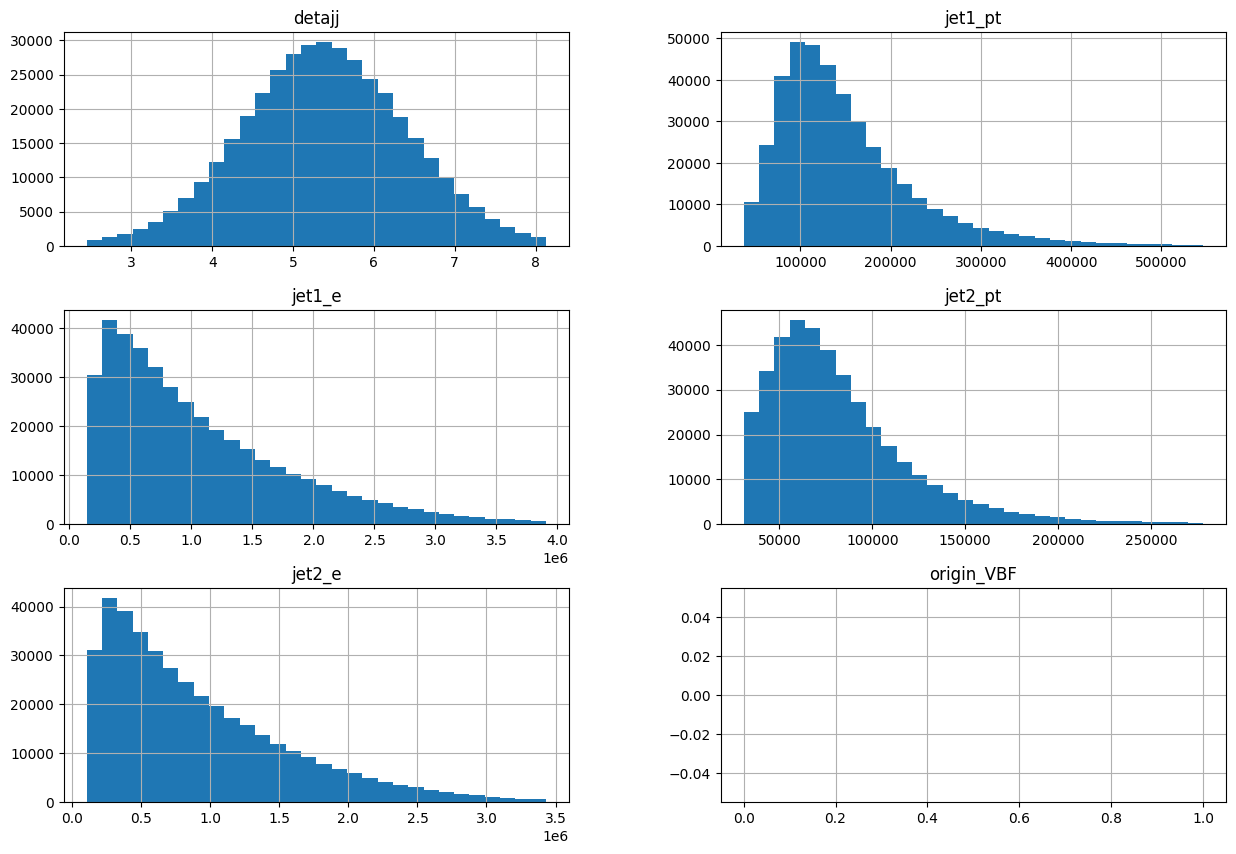

In [13]:
df_plot = df_ml2[(df_ml2 > df_ml2.quantile(0.005)) & (df_ml2 < df_ml2.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# ANALISIS DE DATOS

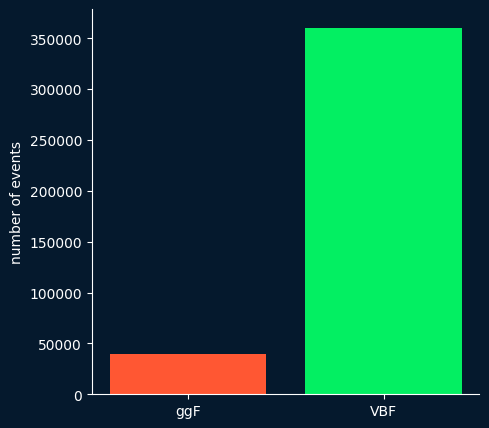

          detajj        jet1_pt        jet1_e        jet2_pt        jet2_e  \
0       5.130603  104969.406250  1.273288e+06   98169.875000  3.498132e+05   
1       7.156201   72039.820312  1.369027e+06   56599.265625  9.561007e+05   
2       6.255918  120273.304688  6.569827e+05   39280.699219  9.452691e+05   
3       4.557185  189834.156250  1.754382e+06   72083.078125  1.938794e+05   
4       5.296212  185329.890625  5.636762e+05  104825.007812  1.771840e+06   
...          ...            ...           ...            ...           ...   
400510  5.910862  153233.453125  1.205820e+06   33497.703125  3.950761e+05   
400511  5.570216   94238.859375  6.042351e+05   68172.960938  7.038728e+05   
400512  6.604571   43778.152344  4.563027e+05   32387.500000  5.755651e+05   
400513  6.322570   51457.390625  8.928492e+05   42295.820312  3.411398e+05   
400514  4.996354   97852.765625  8.217519e+05   77802.210938  3.481841e+05   

        origin_VBF  
0                1  
1                1  


In [14]:
n_ggF = df_ml2[df_ml2["origin_VBF"] == 0].count()[0]
n_VBF = df_ml2[df_ml2["origin_VBF"] == 1].count()[0]
plot_cantidad_ggf_vbf(n_ggF, n_VBF)
print(df_ml2)

# MACHINE LEARNING

In [15]:
from bokbokbok.eval_metrics.classification import F1_Score_Binary
from sklearn.metrics import f1_score

params = {'seed': 123,
          "learning_rate":0.1,
          "max_depth":7,
          # "n_estimators":500,
          "eval_metric":["logloss", "auc"],
          "verbosity":2,
          "objective":"binary:logistic",
          "gamma":0.1, # esto es para evitar el sobreajuste, limita la creacion de ramas
          # 'disable_default_eval_metric': 1, # no usa las metricas de evaluacion que puse arribita (eval_metric)
        #   "device":"cuda"
          }

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

modelo_boost = xgb.train(params,
          dtrain=dtrain,
          num_boost_round=100,
          early_stopping_rounds=10,
          verbose_eval=10,
          maximize=True,
          custom_metric=F1_Score_Binary(average='binary', XGBoost=True),
          # custom_metric=f1_score(average='micro'),
          evals=[(dtrain, 'dtrain'), (dvalid, 'dvalid')])

modelo = XGBRegressor()
modelo._Booster = modelo_boost

[0]	dtrain-logloss:0.32608	dtrain-auc:0.76601	dtrain-F1:0.94770	dvalid-logloss:0.32659	dvalid-auc:0.77289	dvalid-F1:0.94737
[10]	dtrain-logloss:0.26465	dtrain-auc:0.79062	dtrain-F1:0.95535	dvalid-logloss:0.26450	dvalid-auc:0.79597	dvalid-F1:0.95526
[20]	dtrain-logloss:0.25165	dtrain-auc:0.79466	dtrain-F1:0.95646	dvalid-logloss:0.25208	dvalid-auc:0.79836	dvalid-F1:0.95584
[30]	dtrain-logloss:0.24801	dtrain-auc:0.79807	dtrain-F1:0.95667	dvalid-logloss:0.24943	dvalid-auc:0.79890	dvalid-F1:0.95595
[36]	dtrain-logloss:0.24695	dtrain-auc:0.79936	dtrain-F1:0.95675	dvalid-logloss:0.24900	dvalid-auc:0.79904	dvalid-F1:0.95593


In [16]:
modelo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

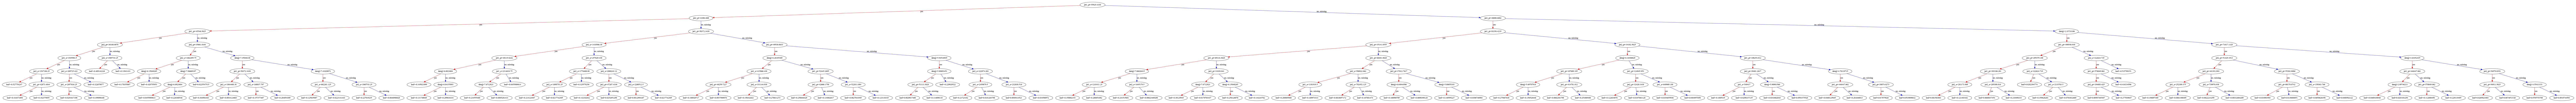

In [17]:
grafico_decisiones(modelo)

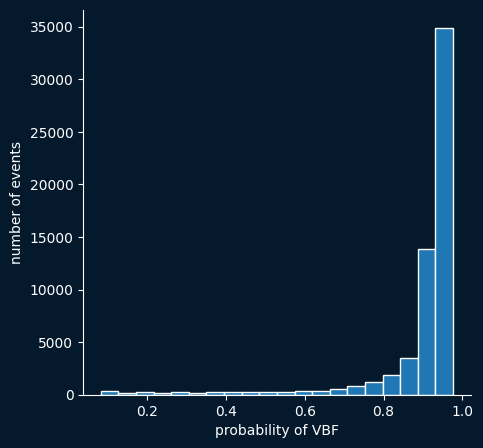

In [18]:
plot_number_events_hist(modelo, X_test)

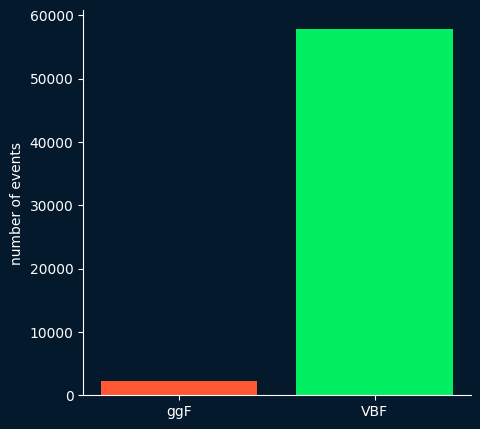

2185
57892
0.03636999184380046
0.9636300081561996


In [19]:
y_pred = modelo.predict(X_test)
n_ggF = y_pred[y_pred<0.5].shape[0]
n_VBF = y_pred[y_pred>0.5].shape[0]

plot_cantidad_ggf_vbf(n_ggF, n_VBF)

ggf_percentage = n_ggF/(n_ggF+n_VBF)
vbf_percentage = n_VBF/(n_ggF+n_VBF)

print(n_ggF)
print(n_VBF)
print(ggf_percentage)
print(vbf_percentage)

In [20]:
precision(modelo, X_test, y_test)

Precisión del modelo: 91.69%


In [21]:
y_pred = modelo.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

,0,1
0,53442,540
1,4450,1645


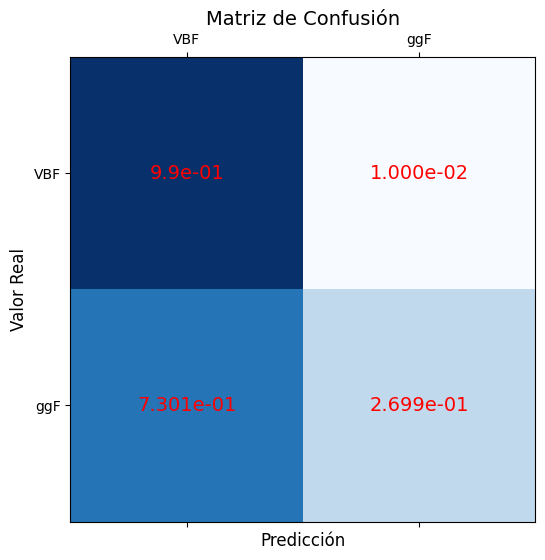

In [22]:
plot_matriz(matriz, porcentaje = False, normalizado=True)

In [23]:
def eficiencia_corte_matriz(matriz):
    eventos_antes = matriz[0][0] + matriz[0][1] + matriz[1][0] + matriz[1][1]
    eventos_despues = matriz[0][0] + matriz[0][1]
    eficiencia = eventos_despues/eventos_antes
    return eficiencia

print(eficiencia_corte_matriz(matriz))

0.8985468648567672


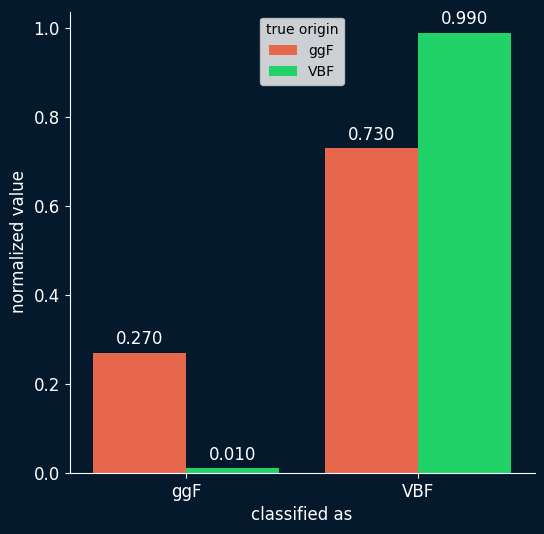

In [24]:
plot_confusion_barras(matriz)

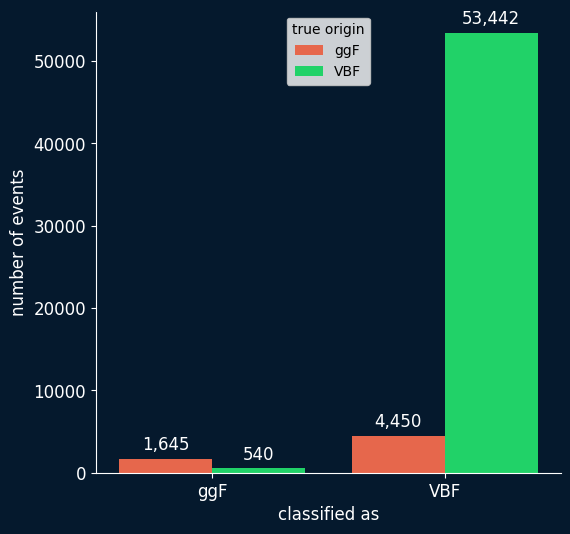

In [25]:
plot_confusion_barras(matriz, normalizado=False)

In [26]:
# Encontrar mejor modelo
# best_model = find_best_model(X_train, y_train, X_test, y_test, X_val, y_val)

In [27]:
from sklearn.metrics import f1_score
y_pred = modelo.predict(X_test)
f1_score(y_test, y_pred>0.5)

0.9553962493519494

In [28]:
modelo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Supongamos que 'X' es tu conjunto de datos original
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(df_X.sample(100, random_state=1))
# # X_tsne = tsne.fit_transform(df_X)

In [30]:
# plt.figure(figsize=[5, 5])
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_y.sample(100, random_state=1).to_numpy(), cmap='viridis', marker='.')
# # plt.plot(X_tsne[:, 0], X_tsne[:, 1])
# plt.show()

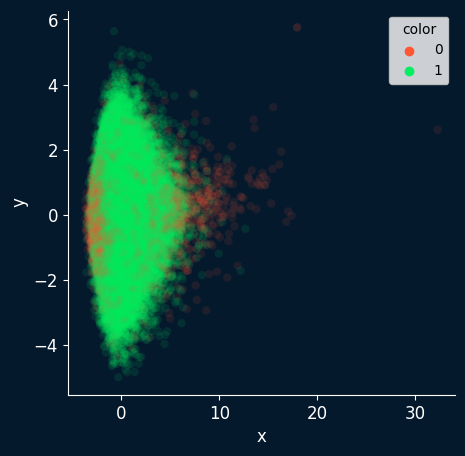

In [31]:
plot_pca_2D(modelo, 
            df_X.sample(100000, random_state=123), 
            df_y.sample(100000, random_state=123))
        #  pd.DataFrame(modelo.predict(df_X)).sample(100000, random_state=123))

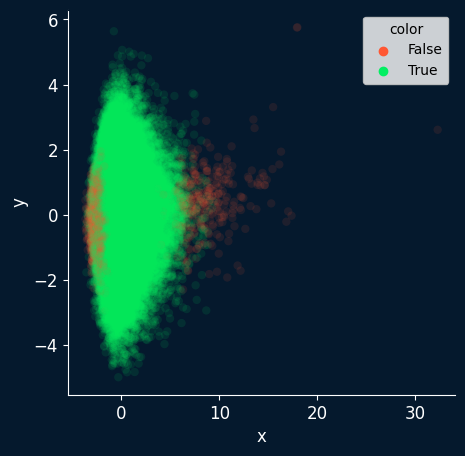

In [32]:
plot_pca_2D(modelo, 
            df_X.sample(100000, random_state=123), 
            # df_y.sample(100000, random_state=123))
            pd.DataFrame(modelo.predict(df_X)>0.5).sample(100000, random_state=123))

In [33]:
importancia = dict(zip(modelo.feature_names_in_, modelo.feature_importances_))
df_importancia = pd.DataFrame(modelo.feature_importances_, index=modelo.feature_names_in_, columns=["importances"])
importancias_ordenadas = df_importancia.sort_values(by=["importances"], ascending=False)
importancias_ordenadas

,importances
jet1_pt,0.564461
jet2_pt,0.255639
detajj,0.139993
jet2_e,0.021022
jet1_e,0.018885


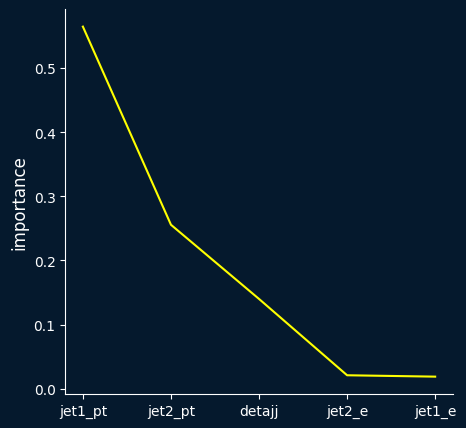

In [34]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(importancias_ordenadas, color='yellow')
ax.set_ylabel("importance", color='white', fontsize=12)

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()